<a href="https://colab.research.google.com/github/denistoo749/Malaria-Cell-Image-Classification/blob/main/malaria_cell_image_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Malaria Cell Image Classification

## Load and preprocess images
using high-level Keras preprocessing utilities (such as `tf.keras.utils.image_dataset_from_directory`) and layers (such as `tf.keras.layers.Rescaling`) to read a directory of images on disk.

# Getting Workspace ready:

In [ ]:
# Import necessary tools
import numpy as np
import os
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
print(f'TF version: {tf.__version__}')

# Check for GPU availability
print('GPU', 'avilability (YESSSS!!!!!)' if tf.config.list_physical_devices('GPU') else 'not available :(')

TF version: 2.15.0
GPU avilability (YESSSS!!!!!)


# Download the Cell Images dataset
Uses a dataset of several thousand photos of cell images. The cell images dataset contains two sub-directories, one per class:
```
cell_images/
  Parasitized/
  Uninfected/
```

In [ ]:
import pathlib
dataset_url = "https://data.lhncbc.nlm.nih.gov/public/Malaria/cell_images.zip"
archive = tf.keras.utils.get_file(origin=dataset_url, extract=True)
data_dir = pathlib.Path(archive).with_suffix('')

In [ ]:
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

27558


Each directory contains cell images:

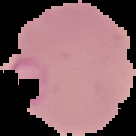

In [ ]:
parasitized = list(data_dir.glob('Parasitized/*'))
PIL.Image.open(str(parasitized[0]))

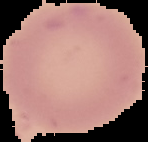

In [ ]:
uninfected = list(data_dir.glob('Uninfected/*'))
PIL.Image.open(str(uninfected[0]))

# Load data using a Keras utility
Let's load these images off disk using the helpful `tf.keras.utils.image_dataset_from_directory utility`.

# Create a dataset
Define some parameters for the loader:

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

It's good practice to use a validation split when developing your model. You will use 80% of the images for training and 20% for validation.

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 22047 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 27558 files belonging to 2 classes.
Using 5511 files for validation.


You can find the class names in the `class_names` attribute on these datasets.

In [ ]:
class_names = train_ds.class_names
print(class_names)

['Parasitized', 'Uninfected']


# Visualize the data
Here are the first twenty images from the training dataset.

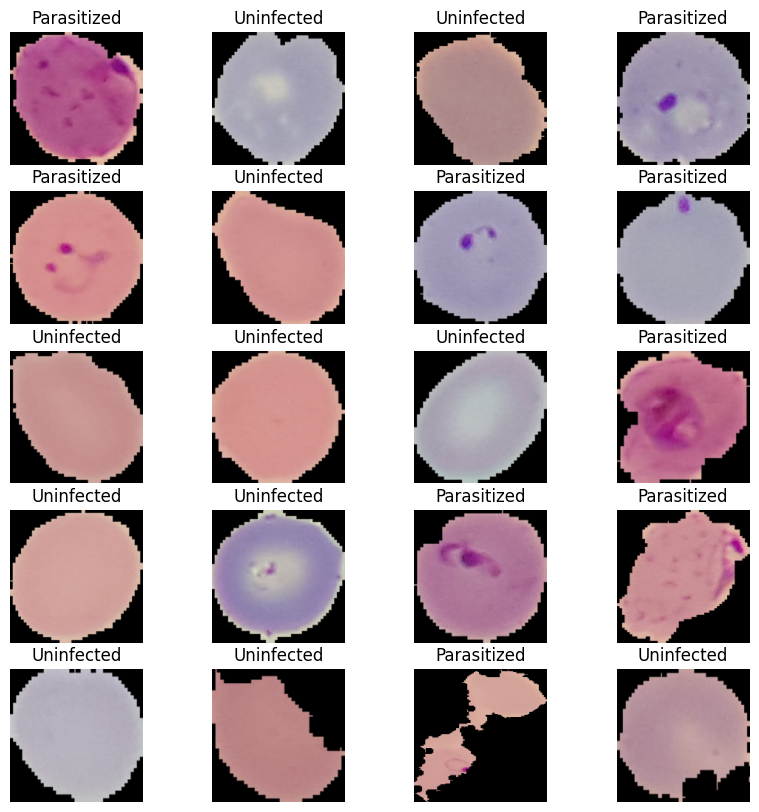

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(20):
    ax = plt.subplot(5, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

# Standardize the data
The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network; in general you should seek to make your input values small.

Here, you will standardize values to be in the `[0, 1]` range by using `tf.keras.layers.Rescaling`:

In [ ]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

# Configure the dataset for performance
Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data:

* `Dataset.cache` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.
* `Dataset.prefetch` overlaps data preprocessing and model execution while training.

Interested readers can learn more about both methods, as well as how to cache data to disk in the *Prefetching* section of the [Better performance with the tf.data API](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/guide/data_performance.ipynb) guide.

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Train a model

For completeness, you will show how to train a simple model using the datasets you have just prepared.

The [Sequential](https://www.tensorflow.org/guide/keras/sequential_model) model consists of three convolution blocks (`tf.keras.layers.Conv2D`) with a max pooling layer (`tf.keras.layers.MaxPooling2D`) in each of them. There's a fully-connected layer (`tf.keras.layers.Dense`) with 128 units on top of it that is activated by a ReLU activation function (`'relu'`). This model has not been tuned in any way—the goal is to show you the mechanics using the datasets you just created. To learn more about image classification, visit the [Image classification](https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/images/classification.ipynb) tutorial.

In [ ]:
num_classes = 5

model = tf.keras.Sequential([
  tf.keras.layers.Rescaling(1./255),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(32, 3, activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dense(num_classes)
])

Choose the `tf.keras.optimizers.Adam` optimizer and `tf.keras.losses.SparseCategoricalCrossentropy` loss function. To view training and validation accuracy for each training epoch, pass the `metrics` argument to `Model.compile`.

In [ ]:
model.compile(
  optimizer='adam',
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

In [ ]:
model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=10
)

Epoch 1/10
689/689 [==============================] - 45s 58ms/step - loss: 0.3333 - accuracy: 0.8675 - val_loss: 0.2121 - val_accuracy: 0.9367
Epoch 2/10
689/689 [==============================] - 17s 24ms/step - loss: 0.1714 - accuracy: 0.9459 - val_loss: 0.1683 - val_accuracy: 0.9467
Epoch 3/10
689/689 [==============================] - 17s 24ms/step - loss: 0.1394 - accuracy: 0.9560 - val_loss: 0.1739 - val_accuracy: 0.9465
Epoch 4/10
689/689 [==============================] - 17s 24ms/step - loss: 0.1193 - accuracy: 0.9610 - val_loss: 0.1684 - val_accuracy: 0.9517
Epoch 5/10
689/689 [==============================] - 16s 24ms/step - loss: 0.0992 - accuracy: 0.9658 - val_loss: 0.1853 - val_accuracy: 0.9470
Epoch 6/10
689/689 [==============================] - 17s 24ms/step - loss: 0.0859 - accuracy: 0.9709 - val_loss: 0.2014 - val_accuracy: 0.9485
Epoch 7/10
689/689 [==============================] - 17s 24ms/step - loss: 0.0642 - accuracy: 0.9776 - val_loss: 0.2747 - val_accuracy: